<a href="https://colab.research.google.com/github/manthanthakker/BitcoinPrediction/blob/master/AppleStockAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Stock prediction Recurrent Neural Network

Please Note, this notebook is only for exploration purpose and is meant to explore application of LSTMs into financial markets. Please don't trade or make decisions based on these analysis. 

In [0]:
!pip install yfinance
!conda install -c pytorch pytorch-nightly-cpu -y 
!conda install -c fastai torchvision-nightly-cpu -y 
!conda install -c fastai fastai -y 
!pip install tensorflow
!pip install fastai
!conda install nb_conda -y
!pip install dataclasses
!pip install fastai==0.7.0
!pip install keras
!pip install --upgrade pip
!conda remove seaborn -y
!pip uninstall seaborn 
!pip3 --no-cache-dir install seaborn 

In [85]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
import datetime
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

Using TensorFlow backend.


### We will do this in 2 steps:


1.   Fundamental analysis using Yahoo Finance API
2.   Applying Recurrent Neural Network



## Fundamental analysis

In [86]:
apple=yf.Ticker("AAPL")
pd.DataFrame(list(apple.info.items()))
#print(apple.actions)

,0,1
0,language,en-US
1,region,US
2,quoteType,EQUITY
3,quoteSourceName,Delayed Quote
4,currency,USD
5,priceHint,2
6,shortName,Apple Inc.
7,market,us_market
8,regularMarketPrice,236.41
9,regularMarketTime,1571428801


So two important things, price of the stock is **236 dollars**. The regular market change is **234.29 - 237.58**. So If one is enter to buy apple stock once can target for 234 $ for that day.
Looking at the 52 week range: **142.0 - 238.13**, the stock is very volatile and looks inflated at this price and can likely go back down. The fifty day average is **222.745**, so may be one **should wait** to drop a bit and then buy. 

In [87]:
print('Total Dividends:')
print(apple.actions['Dividends'].sum())

print('Total Stock splits since inception')
print(apple.actions['Stock Splits'][apple.actions['Stock Splits']!=0])
apple.actions['Stock Splits'][apple.actions['Stock Splits']!=0].product()


Total Dividends:
16.234360000000002
Total Stock splits since inception
Date
1987-06-16    2.0
2000-06-21    2.0
2005-02-28    2.0
2014-06-09    7.0
Name: Stock Splits, dtype: float64


56.0

Since, inception Apple has given **16.23 dollars** of dividend to their shareholders. Since incpetion, if you had 1 apple stock it has split **4 times** and today you would be having **56 stocks for 1 stock**. 

In [122]:
stockpriceAtInception=apple.history(period="MAX")['Close'][0]
latestStockPrice=apple.history(period="MAX")['Close'][-1:]
stockSplit=apple.actions['Stock Splits'][apple.actions['Stock Splits']!=0].product()

profitSinceInception=(latestStockPrice-stockpriceAtInception)*stockSplit
profitPercentageSinceInception=profitSinceInception/stockpriceAtInception*100
print("Stock Price at inception was",stockpriceAtInception)
print("Stock Price today is",latestStockPrice.to_string(index=False))
print("This is",profitPercentageSinceInception.to_string(index=False),"percetage of profit.")

Stock Price at inception was 0.4089711308479309
Stock Price today is Date
 236.410004
This is Date
 32315.380781 percetage of profit.


If you purchased 1 stock since inception for 0.4 today, you would have 3231538.0781 percetage of profit! Wow!

Okay, now the fundamental analysis is done lets try to predict how is the stock going to behave in the coming days. 

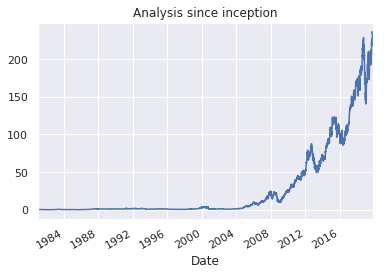

In [137]:
history=apple.history(period="MAX")['Close']
import seaborn as sns; sns.set()
plt.title('Analysis since inception')
history.plot()

So the apple stock price has gained maximum profits since 1998. If you look on the web, that is when Apple Ipods was released and it was spectacular and apple started becoming the industry trend setter. 

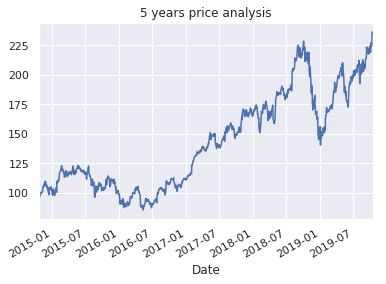

In [138]:
history=apple.history(period="5y")['Close']
import seaborn as sns; sns.set()
plt.title('5 years price analysis')
history.plot()

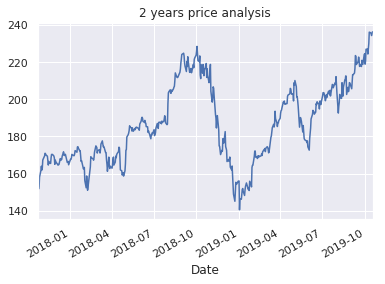

In [140]:
history=apple.history(period="2y")['Close']
import seaborn as sns; sns.set()
plt.title('2 years price analysis')
history.plot()

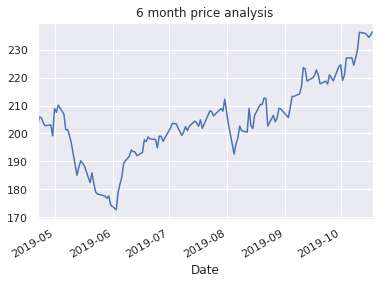

In [145]:
history=apple.history(period="6mo")['Close']
import seaborn as sns; sns.set()
plt.title('6 month price analysis')
history.plot()

#Recurrent Neural network 
RNNs to capture time series data and predict stock price for the next few day

In [159]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series

data=apple.history(period="3y")['Close']


#data=data.set_index(pd.DatetimeIndex(data['Date']))['Close']
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

look_back=7
#data=difference(data,look_back)


#def project(data,look_back):
    #convert an array of values into a dataset matrix
    

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
#scaler=StandardScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
#look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
from keras.layers import Activation, Dense,Dropout
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))
#model.add(LSTM(100, input_shape=(1, look_back)))

model.add(Dense(1))
import keras
from keras import optimizers

#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#data=pd.DataFrame(numpy.concatenate((trainPredict[0:len(trainPredict)-look_back-1],testPredict[0:len(testPredict)-look_back-1])),columns=["predicted"])
#print('one',data.count())
#print('two',dataframe.count())
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])

Epoch 1/50
496/496 [==============================] - 5s 11ms/step - loss: 0.1539
Epoch 2/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0041
Epoch 3/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0258
Epoch 4/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0086
Epoch 5/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0087
Epoch 6/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 7/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0039
Epoch 8/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0031
Epoch 9/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0032
Epoch 10/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 11/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 12/50
496/496 [==============================] - 1s 1ms/step - loss: 0.0103
Epoch 13/50
496/496 [===

The above is a LSTM RNN to predict the stock price of Apple for past X runs. It has been trained on last 67% of the runs and tested on the new runs. 

# Observations
### Lookback 
The lookback parameter is nothing but how much past data will the model be given to predict todays price, one can play around and see the accuracy of the model. for various dates. 
My observation is if you want to predict short term price say, for the next week or so, lookback < 5-20 gives good performance. That seems pretty obvious too, looks like the model is doing nothing but weighted sum of past runs. 
The intresting thing is, the stock price over a longer run, say next 3 months  you need to give past 200-300 days of data and it will actually give you the stock price based on what its value should be. (Its an algorithm purely based on time series and thats why it doesnt take into account any sentiments etc) Why is this important? Say there was a rumour about Apple that some analyst downgraded stocks rating, investers would start selling but the value of the company is unchanged, so the stocks are bound to rise if you take into account the long run. Adding to that this model can be used to leverage many temporal patterns such as stock rises during christmas because may be the sales for iphone is always high. Etc. This is a temporal pattern and having lookback to 365 captures such details. 

### MoreFeatures
I think adding earnings date, iphone sales date and apple launch date can help in analysing more about the common patterns to build strategies to profit from the stock price. 

